In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
cd ..

/Share/home/shibinbin/projects/Deepfold2


In [3]:
import h5py
import seaborn as sns
sns.set()

/dev/shm/shibinbin/anaconda2/lib/python2.7/site-packages/numexpr/cpuinfo.py:42: UserWarning: [Errno 2] No such file or directory
  warnings.warn(str(e), UserWarning, stacklevel=stacklevel)


In [4]:
with h5py.File('output/TE/Spitale_2015_invitro.mm10/TE_transcript_separate.hmmalign.reactivities', 'r') as f:
    reactivities = {}
    sequences = {}
    for te_type in f.keys():
        reactivities[te_type] = f[te_type + '/reactivities'][:]
        sequences[te_type] = f[te_type + '/sequences'][:]

In [5]:
alphabet = np.array(['-', 'A', 'C', 'G', 'T'], dtype=np.character)

In [6]:
print sequences.keys()

[u'B1_Mur4', u'ORR1A2', u'B1_Mur1', u'B2_Mm1t', u'B1_Mur3', u'B1_Mm', u'RLTR20A4', u'X6B_LINE', u'U1', u'RSINE1', u'RLTR17B_Mm', u'B2_Mm1a', u'B4A', u'RLTR19-int', u'PB1', u'LSU-rRNA_Hsa', u'RLTR1B-int', u'MMSAT4', u'PB1D7', u'MIR', u'MT2B', u'RMER4A', u'B1_Mur2', u'ORR1A4', u'MIRb', u'MIRc', u'MER34B-int', u'MER5A', u'B1_Mus2', u'B1F', u'B1_Mus1', u'RLTR45-int', u'RLTR25B', u'MIR3', u'BC1_Mm', u'PB1D10', u'PB1D11', u'RLTR18B', u'L2', u'7SLRNA', u'B2_Mm2', u'MTC', u'U2', u'B1F1', u'B3A', u'MTD', u'B1F2', u'AmnSINE1', u'RLTR20C1_MM', u'MMETn-int', u'ID4', u'MLT1D', u'ID2', u'URR1B', u'URR1A', u'RLTR31D_MM', u'B4', u'MTA_Mm', u'PB1D9', u'B3', u'ID_B1', u'MER20', u'L3']


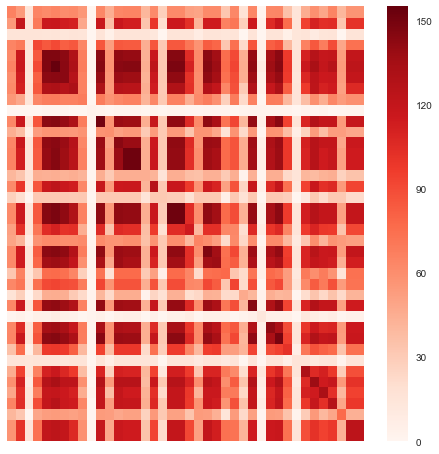

In [7]:
te_type = 'B1_Mur4'
notnan = (~np.isnan(reactivities[te_type])).astype(np.int32)
notnan_cov = notnan.dot(notnan.T)
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(notnan_cov, xticklabels=False, yticklabels=False, cmap=cm.Reds, ax=ax)

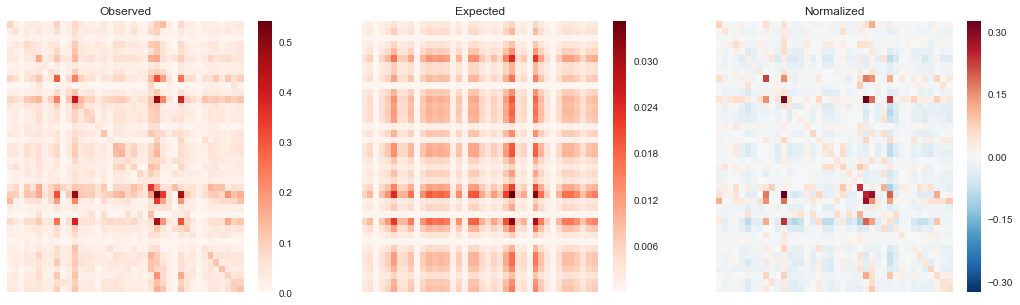

In [165]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
# covariance matrix of raw reactivities
observed = reactivities[te_type].copy()
#r[(~np.isnan(r)) & (r <= 0.01)] = 0
#r[(~np.isnan(r)) & (r > 0.1)] = 1
observed = np.nan_to_num(observed)
observed_cov = observed.dot(observed.T)/np.maximum(notnan_cov, 1)
sns.heatmap(observed_cov, xticklabels=False, yticklabels=False, cmap=cm.Reds, ax=axes[0])
axes[0].set_title('Observed')
# coveriance matrix of average reactivities
expected = np.nanmean(r, axis=1)
expected_cov = expected[np.newaxis, :]*expected[:, np.newaxis]
sns.heatmap(expected_cov, xticklabels=False, yticklabels=False, cmap=cm.Reds, ax=axes[1])
axes[1].set_title('Expected')
# coveriance matrix of observed/expected ratio
#ratios = observed_cov/expected_cov
#sns.heatmap(np.log(ratios + 0.01), xticklabels=False, yticklabels=False, cmap=cm.RdBu_r, ax=axes[2])
#axes[2].set_title('Observed/expected')
# normalize by linear regression
N = observed_cov.shape[0]
ii, jj = np.ogrid[:N, :N]
model = LinearRegression()
model.fit(expected_cov[ii >= jj].reshape((-1, 1)), observed_cov[ii >= jj])
normalized_cov = model.predict(expected_cov.reshape((-1, 1))).reshape((N, N))
sns.heatmap(observed_cov - normalized_cov, xticklabels=False, yticklabels=False, cmap=cm.RdBu_r, ax=axes[2])
axes[2].set_title('Normalized')

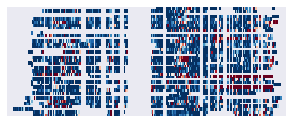

In [14]:
fig, ax = plt.subplots(figsize=(5, 2))
sns.heatmap(reactivities[te_type], xticklabels=False, yticklabels=False, cmap=cm.RdBu_r, ax=ax, cbar=False)

In [18]:
fig, ax = plt.subplots(figsize=(5, 0.2))
sns.heatmap(np.nanmean(reactivities[te_type], axis=0).reshape((1, -1)),
            xticklabels=False, yticklabels=False, cmap=cm.RdBu_r, ax=ax, cbar=False)

/dev/shm/shibinbin/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


In [166]:
np.nanstd(np.full(10, np.nan))

/dev/shm/shibinbin/anaconda2/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1423: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


nan

/dev/shm/shibinbin/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in divide
  # This is added back by InteractiveShellApp.init_path()


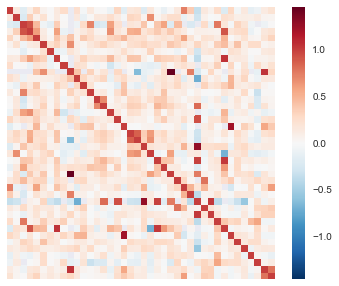

In [173]:
def nan_corr(X):
    '''Correlation matrix with NaNs
    x: matrix if shape ()
    '''
    N, M = X.shape
    notnan = (~np.isnan(X)).astype(np.int32)
    notnan_cov = notnan.dot(notnan.T)
    X_std = np.nanstd(X, axis=1)
    X -= np.nanmean(X, axis=1, keepdims=True)
    X = np.nan_to_num(X)
    X_corr = X.dot(X.T)/notnan_cov/(X_std[:, np.newaxis]*X_std[np.newaxis, :])
    return X_corr
observed_corr = nan_corr(reactivities[te_type].copy())
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(observed_corr, xticklabels=False, yticklabels=False, cmap=cm.RdBu_r, ax=ax)

In [131]:
from sklearn.linear_model import LinearRegression

In [149]:
N = observed.shape[0]
ii, jj = np.ogrid[:N, :N]
model = LinearRegression(in)
model.fit(expected_cov[ii >= jj].reshape((-1, 1)), observed_cov[ii >= jj])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [153]:
print(model.coef_, model.intercept_)

(array([ 8.11697578], dtype=float32), 0.0095843822)


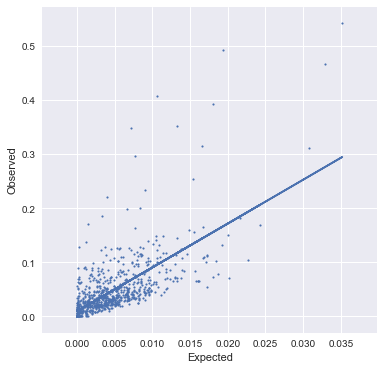

In [158]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(expected_cov[ii >= jj], observed_cov[ii >= jj], s=3, label='Observed')
ax.plot(expected_cov[ii >= jj], model.predict(expected_cov[ii >= jj].reshape((-1, 1))), label='Predicted')
ax.set_xlabel('Expected')
ax.set_ylabel('Observed')

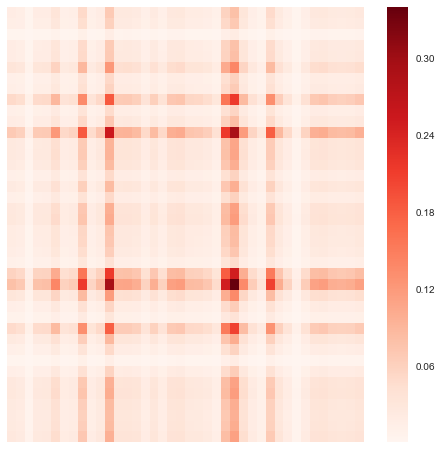

In [113]:
r = reactivities[te_type].copy()
#r[(~np.isnan(r)) & (r <= 0.01)] = 0
#r[(~np.isnan(r)) & (r > 0.1)] = 1
r = np.nanmean(r, axis=1)
r_cov = r[np.newaxis, :]*r[:, np.newaxis]
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(r_cov, xticklabels=False, yticklabels=False, cmap=cm.Reds, ax=ax)

In [110]:
r.shape

(289,)

/dev/shm/shibinbin/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


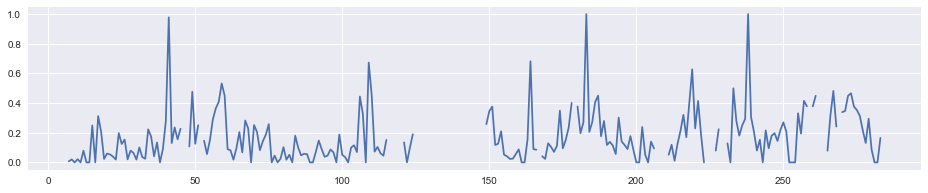

In [105]:
fig, ax = plt.subplots(figsize=(16, 3))
ax.plot(np.nanmean(reactivities[te_type], axis=0))

In [87]:
S, U = np.linalg.eigh(r_cov)

(0, 20)

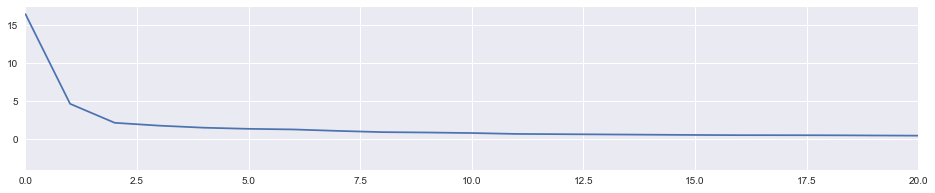

In [91]:
fig, ax = plt.subplots(figsize=(16, 3))
ax.plot(S[::-1])
ax.set_xlim(0, 20)

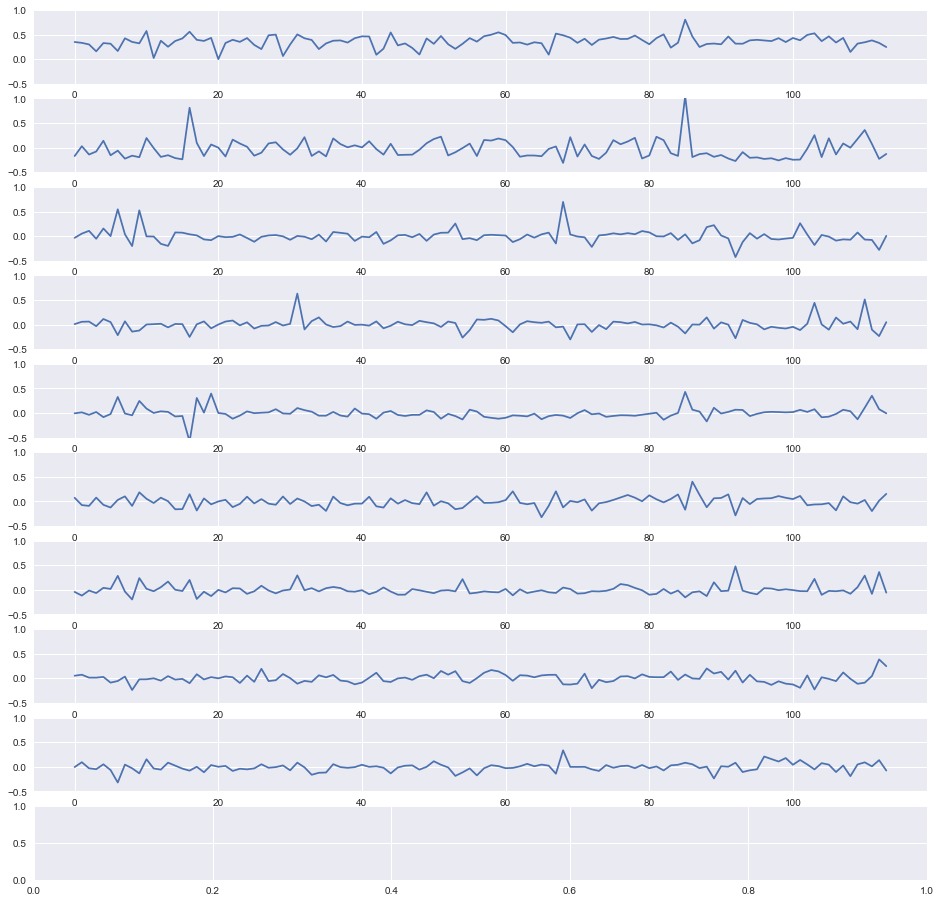

In [100]:
fig, axes = plt.subplots(10, 1, figsize=(16, 16))
for i in range(1, 10):
    axes[i - 1].plot(np.sqrt(S[-i])*U[:, -i])
    axes[i - 1].set_ylim(-0.5, 1)

In [27]:
import scipy.stats

1.331998002
0.999000999
0.666000666


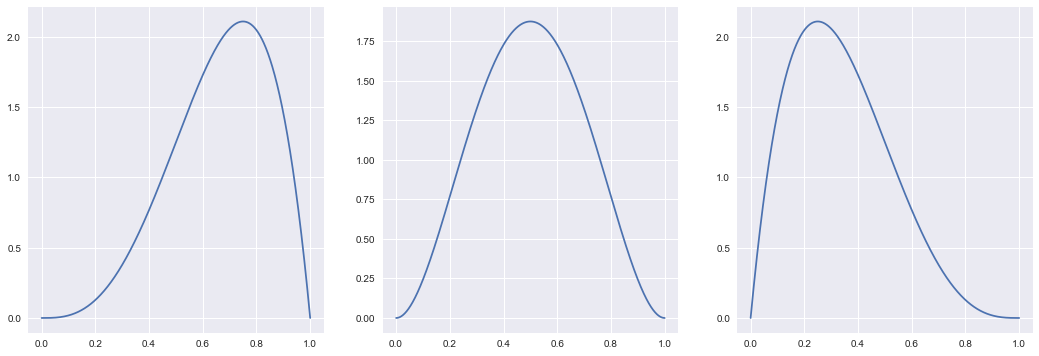

In [81]:
x = np.linspace(0, 1, 1001, endpoint=True)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
p = scipy.stats.beta.pdf(x, 4, 2)
print(np.sum(x*p)/np.sum(x))
axes[0].plot(x, p)
p = scipy.stats.beta.pdf(x, 3, 3)
print(np.sum(x*p)/np.sum(x))
axes[1].plot(x, p)
p = scipy.stats.beta.pdf(x, 2, 4)
print(np.sum(x*p)/np.sum(x))
axes[2].plot(x, p)

In [77]:
np.sum(x*p)/np.sum(x)

0.65999999312926561

In [48]:
scipy.stats.beta.pdf?